<a href="https://colab.research.google.com/github/hamsungmin/DataTrainAnalysis/blob/main/project_week6_%EB%B3%B4%EC%8A%A4%ED%84%B4_%EC%A7%91%EA%B0%92_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 보스턴 집값 예측 모형 만들기

보스턴 집값 데이터를 이용하여, 집값 예측 모형을 만듭니다.
- Linear Regression, RandomForest, XGBoost를 사용하여 best 모형을 만듭니다.
- K-fold 등의 모형 성능 향상 기법 사용은 자유입니다.(필수X)
- AutoML 사용은 자유이나, Pycaret은 타 패키지 의존성이 높고, Colab 환경 특성상 많은 라이브러리를 다시 지우고 설치해야할 수 있어, 추천하지 않습니다.
- SHAP을 이용하여 모형을 해석하고, 해석한 결과를 텍스트로 정리하여 text 셀에 입력합니다.
- Streamlit을 이용하여 보스턴 집값을 예측하는 웹앱을 제작합니다.
- Streamlit으로 만든 웹앱은 집값 예측한 결과를 캡쳐하여 같이 구글폼에  제출합니다.


### 컬럼 설명

<br>CRIM: 자치시(town)별 1인당 범죄율
<br>ZN: 25,000 평방피트를 초과하는 거주지역의 비율
<br>INDUS: 비소매상업지역이 점유하고 있는 토지의 비율
<br>CHAS: 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
<br>NOX: 10ppm 당 농축 일산화질소
<br>RM: 주택 1가구당 평균 방의 개수
<br>AGE: 1940년 이전에 건축된 소유주택의 비율
<br>DIS: 5개의 보스턴 직업센터까지의 가중 거리
<br>RAD: 방사형 고속도로 접근성 지수
<br>TAX: 10,000 달러 당 재산세율
<br>PTRATIO: 자치시(town)별 학생/교사 비율
<br>B: 1000(Bk - 0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말한다.
<br>LSTAT: 모집단의 하위 계층의 비율(%)
<br>PRICE: 본인 소유의 주택 가격(중앙값, $1,000)

In [ ]:
# 1. 패키지 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import matplotlib.pyplot as plt
import pickle

# 2. 데이터 로딩
df = pd.read_csv("/content/boston.csv")  # 업로드한 파일
X = df.drop(columns=["PRICE"])
y = df["PRICE"]

# 모델링

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [ ]:
def modelRegressionStudy(model_name, model, X_train, y_train, X_test, y_test):
    trained_models = {}

    model.fit(X_train, y_train) #모델 학습

    y_pred = model.predict(X_test) #모델 예측

    mse = mean_squared_error(y_test, y_pred) #MSE
    mae = mean_absolute_error(y_test, y_pred) #MAE
    r2 = r2_score(y_test, y_pred) #R2
    rmse = np.sqrt(mse) #RMSE

    trained_models["mse"] = mse
    trained_models["mae"] = mae
    trained_models["r2"] = r2
    trained_models["rmse"] = rmse

    return trained_models

In [ ]:
# 3. 데이터 분할
# 훈련 데이터와 테스트 데이터로 분할
# 전체 데이터의 20%를 테스트 데이터로 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 모델 학습 및 성능 비교
# Linear Regression, RandomForest, XGBoost
# 학습할 모델 정리
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}
best_score = 0
best_model_name = ""
best_model = None

for model_name, model in models.items():
    # 함수로 만들어 코드 정리
    trained_models = modelRegressionStudy(model_name, model, X_train, y_train, X_test, y_test)
    print(f"{model_name} 모델 성능 : {trained_models}")
    # 5. model selection by RMSE
    if trained_models.get("rmse") < best_score or best_score == 0:
        best_score = trained_models.get("rmse")
        best_model_name = model_name
        best_model = model

print(f'best model: {best_model_name}, rmse best score: {best_score}')

# 6. Best 모델 저장
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


LinearRegression 모델 성능 : {'mse': 24.291119474973478, 'mae': 3.189091965887837, 'r2': 0.6687594935356326, 'rmse': np.float64(4.928602182665332)}
RandomForest 모델 성능 : {'mse': 8.541608931372553, 'mae': 2.0885784313725497, 'r2': 0.8835242290350845, 'rmse': np.float64(2.922603108766661)}
XGBoost 모델 성능 : {'mse': 6.909231565384943, 'mae': 1.8908873698290656, 'r2': 0.9057837838492537, 'rmse': np.float64(2.62854171840299)}
best model: XGBoost, rmse best score: 2.62854171840299


# SHAP

------------------------------------------ 요약 그림 ------------------------------------------


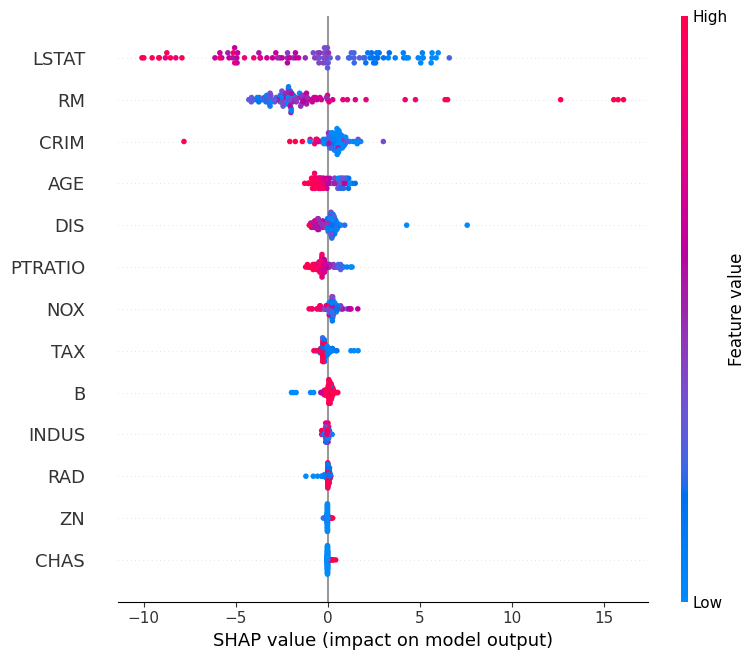

------------------------------------------ 워터폴 플롯 ------------------------------------------


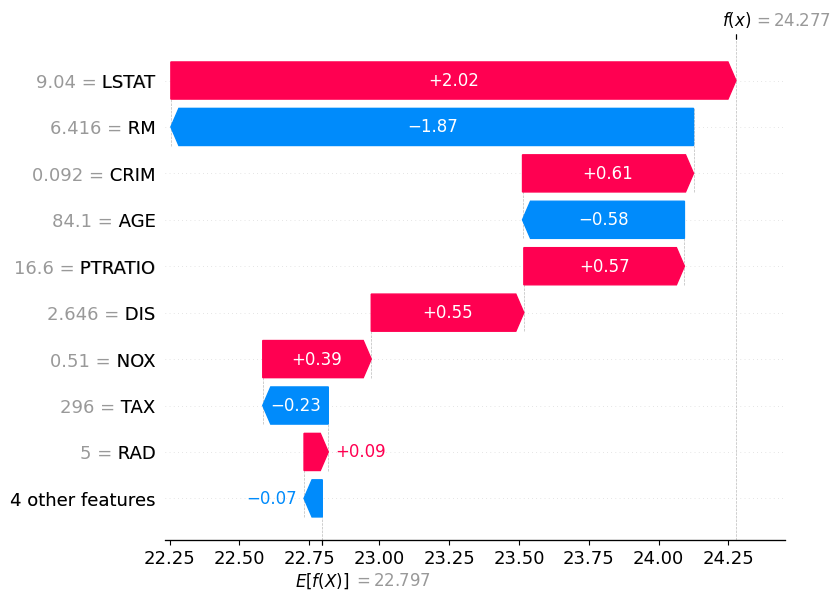

In [ ]:
# 6. SHAP 해석
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test, check_additivity=False)
# SHAP 요약 그림
print("------------------------------------------ 요약 그림 ------------------------------------------")

shap.summary_plot(shap_values, X_test)
# SHAP 워터폴 플롯 (특정 샘플)
print("------------------------------------------ 워터폴 플롯 ------------------------------------------")
shap.waterfall_plot(shap_values[0])


# SHAP 해석

LSTAT: 모집단의 하위 계층의 비율(%)
<br>RM: 주택 1가구당 평균 방의 개수
<br>CRIM: 자치시(town)별 1인당 범죄율
<br>AGE: 1940년 이전에 건축된 소유주택의 비율
<br>PTRATIO: 자치시(town)별 학생/교사 비율
<br>DIS: 5개의 보스턴 직업센터까지의 가중 거리

1. LSTAT : 하위 계층이 많을수록 집가격이 낮아진다
2. RM : 높을수록 가격이 높아진다. 방이 많을수록 가격이 올라간다
3. CRIM : 범죄율이 높을수록 집값이 낮아진다
4. AGE : 1940년 이전 오래된 집 비율이 높아지면 집 값도 올라간다(? 오래될수록 비싸다?)
5. PTRATIO : 학생/교사 비율이 높을수록 집값도 오른다(교육적인 환경)
6. DIS : 직업센터 거리가 가까울수록 집값이 올라간다

# Streamlit

In [ ]:
!pip install streamlit -q
!npm install localtunnel -q
!pip install "ipywidgets>=7, <8" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.5 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
added 22 packages in 2s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# 모델과 샘플 데이터 로딩
with open("/content/best_model.pkl", 'rb') as f:
    model = pickle.load(f)
df = pd.read_csv("/content/boston.csv")
X = df.drop(columns=["PRICE"])
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Streamlit 페이지 설정
# 입력 폼 생성, 2개의 열 구조
col1, col2 = st.columns(2)

# 입력 폼 구성 (간단한 변수만 선택)
st.sidebar.header("입력 정보")
with col1:
    CRIM = st.number_input(
            "범죄율을 입력하세요",
            min_value=0,
            max_value=100,
            value=0
        )
    RM = st.number_input(
            "주택 1가구당 평균 방의 개수",
            min_value=0,
            value=0
        )
    LSTAT = st.number_input(
            "모집단의 하위 계층의 비율",
            min_value=0,
            max_value=100,
            value=0
        )
with col2:
    PTRATIO = st.number_input(
            "자치시(town)별 학생/교사 비율",
            min_value=0,
            max_value=100,
            value=0
        )
    TAX = st.number_input(
            "10,000 달러 당 재산세율",
            min_value=0,
            value=0
        )

# 나머지 변수는 평균값으로 고정
input_data = pd.DataFrame([X.mean()])
input_data["CRIM"] = CRIM
input_data["RM"] = RM
input_data["LSTAT"] = LSTAT
input_data["PTRATIO"] = PTRATIO
input_data["TAX"] = TAX

# 예측 및 해석
if st.button("예측 실행"):
    pred = model.predict_proba(input_data)[0][1]
    st.success(f"🏠 예측된 집값: **{pred:.2f} 천 달러**")

    # SHAP 해석 시각화(입력 샘플)
    st.markdown("### 📊 예측 해석 (SHAP)")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test, check_additivity=False)

    # Matplotlib 기반 그림 표시
    fig, ax = plt.subplots()
    shap.plots.waterfall(shap_values[0], show=False)
    st.pyplot(fig)

    # 입력값 표시
    st.markdown("### 📌 입력값 확인")
    st.table(input_data)

# Streamlit 기본 스타일 제거
st.markdown("""
    <style>
    #MainMenu {visibility: hidden;}
    footer {visibility: hidden;}
    </style>
""", unsafe_allow_html=True)


Overwriting app.py


In [ ]:
!streamlit run /content/app.py & npx lt --port 8501



⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.243.169.220:8501

your url is: https://stale-chairs-rush.loca.lt
  Stopping...
^C


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

# 데이터 불러오기 및 분할 (튜닝을 위해 훈련 세트를 사용합니다)
df = pd.read_csv('/content/boston.csv')
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 객체 생성
xgb_model = XGBRegressor(random_state=42)

# 튜닝할 하이퍼파라미터와 후보 값들을 딕셔너리로 정의
# n_estimators: 부스팅 라운드 수 (모델 복잡도)
# max_depth: 트리의 최대 깊이 (과적합 제어)
# learning_rate: 학습률 (모델의 학습 속도)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           verbose=1,
                           n_jobs=1)

# 훈련 데이터로 그리드 서치 실행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 최고 성능 출력
print("--- 그리드 서치 결과 ---")
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"최고 점수: {grid_search.best_score_:.4f}")

# 최적의 모델 추출
best_model = grid_search.best_estimator_

# 최적 모델의 테스트 세트 성능 평가
test_score = best_model.score(X_test, y_test)
print(f"최적 모델의 테스트 : {test_score:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
--- 그리드 서치 결과 ---
최적의 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
최고 점수: 0.8629
최적 모델의 테스트 : 0.9199
